# Parallelism Demo

Consider $f\,$  where

$$f(t) = \sum_{k\in\mathbb{N}}^{\infty}(-1)^k\dfrac{\sin[(2k+1) x]}{(2k+1)^2}$$


In [1]:
from plt_style import *
import numpy as np
import pylab as plt
import scipy as sp


In [2]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                40
On-line CPU(s) list:   0-39
Thread(s) per core:    1
Core(s) per socket:    20
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
Stepping:              1
CPU MHz:               3224.804
CPU max MHz:           3600.0000
CPU min MHz:           1200.0000
BogoMIPS:              4390.05
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              51200K
NUMA node0 CPU(s):     0-19
NUMA node1 CPU(s):     20-39
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonsto

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           503G         11G        452G        634M         39G        489G
Swap:          4.0G         37M        4.0G


In [4]:
N = 2**27+1 # 2**27 * 8 bytes -> 2**30/2**30 = 1 GiB of data
t = np.linspace(0,10*np.pi,N)[:-1]

In [5]:
%%time
f = np.array([ (-1)**k*np.sin(ell*t)/ell**2 for k,ell in enumerate(2*np.arange(31)+1) ]).sum(axis=0)

CPU times: user 2min 12s, sys: 1min 10s, total: 3min 23s
Wall time: 31.3 s


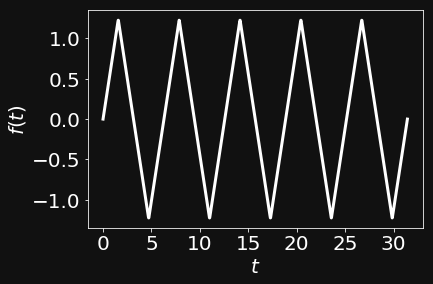

In [6]:
skip  = 1000
ts,fs= [ u[::skip] for u in [t,f] ]
plt.figure(facecolor='#111111')
plt.plot(ts,fs,'w-',lw=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$t$',fontsize=20,color='w')
_=plt.ylabel(r'$f(t)$',fontsize=20,color='w')

In [7]:
%%time
mkl_set_num_threads(1)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 1
CPU times: user 5.85 s, sys: 2.07 s, total: 7.92 s
Wall time: 7.9 s


In [8]:
%%time
mkl_set_num_threads(4)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 4
CPU times: user 2.88 s, sys: 1.16 s, total: 4.04 s
Wall time: 4.04 s


In [9]:
%%time
mkl_set_num_threads(10)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 10
CPU times: user 2.93 s, sys: 1.11 s, total: 4.04 s
Wall time: 4.04 s


In [10]:
!uptime

 14:48:10 up 19 days, 23:35,  4 users,  load average: 2.25, 0.78, 0.59


In [11]:
tau = 10*np.pi
om0 = 2*np.pi/tau
om  = om0*np.arange(len(q))
p   = q/q.max()
k   = np.linspace(1,11,1001)

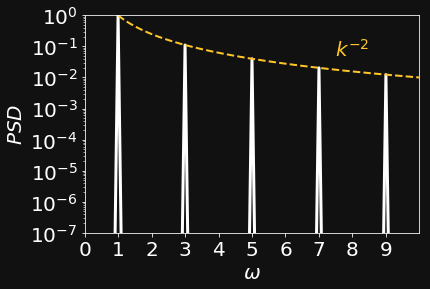

In [12]:
plt.figure(facecolor='#111111')
plt.semilogy(om,p,'w-',lw=3)
plt.semilogy(k,1/k**2,'--',c=gld,lw=2)
plt.annotate(r'$k^{-2}$',(8,5e-2),fontsize=20,color=gld,ha='center')
_=plt.xlim(0,10)
_=plt.ylim(1e-7,1)
_=plt.xticks(np.arange(10),fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$\omega$',fontsize=20,color='w')
_=plt.ylabel(r'$PSD$',fontsize=20,color='w')

## Einsum On the CPU

Consider 

$$U(x,y,z) = \sum_{\ell\in\mathbb{N}\,odd}^{\infty}\dfrac{\cos(\ell x)\sin(\ell z)}{\ell^3}$$

for $(x,y,z)\in[0,\pi]^3$. Then, in the $xz$-plane, $\partial U/\partial x$ is the convolution of two orthogonal triangle waves.

In [13]:
import cheb

In [14]:
N = 256
Do,xo = cheb.cheb(N)
D,x = Do*2/np.pi,(xo+1)*np.pi/2
sanity = np.isclose( (D@x).sum()/(N+1),1)
print(f"Sanity: {sanity.__repr__():s}")

Sanity: True


In [15]:
X,Y,Z = np.meshgrid(x,x,x,indexing='ij')
U = np.array([ np.cos(ell*X)*np.sin(ell*Z)/ell**3 for ell in 2*np.arange(31)+1 ]).sum(axis=0)

In [16]:
mkl_set_num_threads(40)

Threads: 40 > 10 Max Threads
MKL THREADS SET: 1


In [17]:
%%time
dUdx = np.einsum('ij,jkl->ikl',D,U)

CPU times: user 4.73 s, sys: 53.5 ms, total: 4.79 s
Wall time: 4.79 s


In [18]:
dUdx_iter = 0*dUdx

In [19]:
%%time
for k in range(U.shape[-1]):
    dUdx_iter[:,:,k] = D @ U[:,:,k]

CPU times: user 457 ms, sys: 2.91 ms, total: 460 ms
Wall time: 457 ms


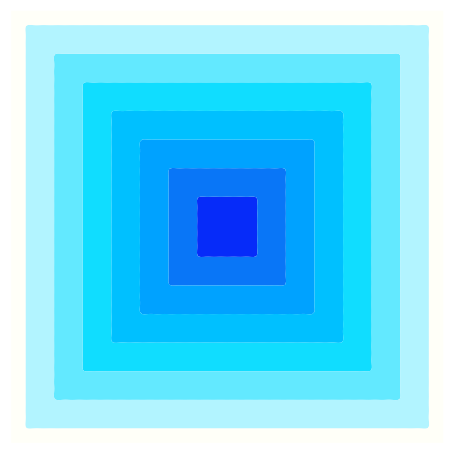

In [20]:
f,a = no_ax_fax()
L   = np.abs(dUdx).max() * np.linspace(-1,1,16)
mycontourf(X[:,128,:],Z[:,128,:],dUdx[:,128,:],L,cmap=mycm15)